Episode 0
Step 1 of Episode 0
obs_tuple: (-0.6, 0.10000000000000009, 0.0, 0.0, 0.20000000000000018, -0.29999999999999993, 0.0, 0.0)
Action agent0: tensor([[0, 0]], device='cuda:0')
obs_tuple: (0.6000000000000001, 0.20000000000000018, 0.0, 0.0, 0.20000000000000018, -0.29999999999999993, 0.0, 0.0)
Action agent1: tensor([[0., 0.]], device='cuda:0', dtype=torch.float64)
Step 2 of Episode 0
obs_tuple: (-0.6, 0.10000000000000009, 0.0, 0.0, 0.20000000000000018, -0.29999999999999993, 0.0, 0.0)
Action agent0: tensor([[0, 0]], device='cuda:0')
obs_tuple: (0.6000000000000001, 0.20000000000000018, 0.0, 0.0, 0.20000000000000018, -0.29999999999999993, 0.0, 0.0)
Action agent1: tensor([[0., 0.]], device='cuda:0', dtype=torch.float64)
Step 3 of Episode 0
obs_tuple: (-0.6, 0.10000000000000009, 0.0, 0.0, 0.20000000000000018, -0.29999999999999993, 0.0, 0.0)
Action agent0: tensor([[0, 0]], device='cuda:0')
obs_tuple: (0.6000000000000001, 0.20000000000000018, 0.0, 0.0, 0.20000000000000018, -0.29999999999999

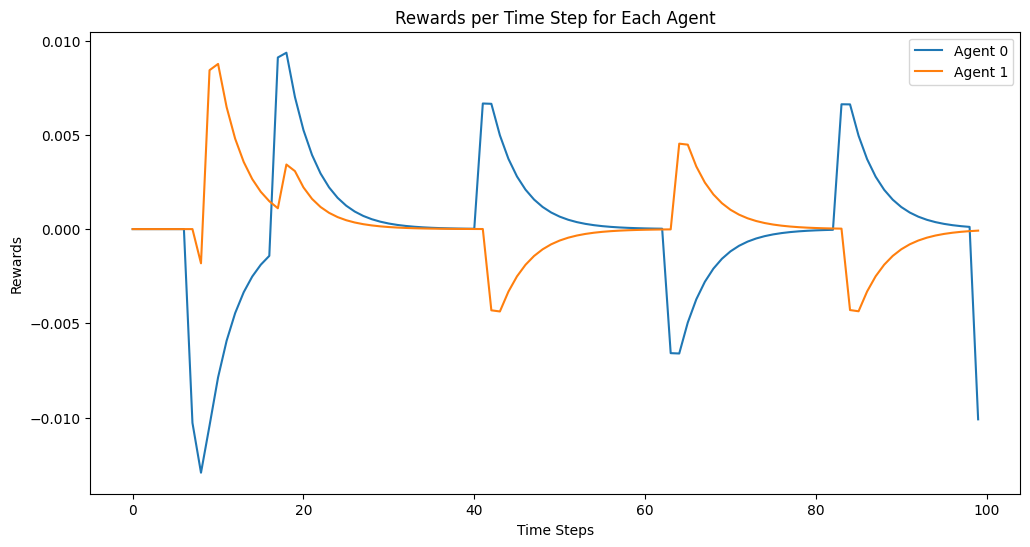

MoviePy - Building file navigation_comm.gif with imageio.


In [9]:
import time
import torch
from vmas import make_env
from vmas.simulator.core import Agent
from vmas.simulator.scenario import BaseScenario
from typing import Union
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML, display as ipython_display
import numpy as np
import matplotlib.pyplot as plt
from gym.spaces import Discrete 

class QLearningAgent:
    def __init__(self, env, agent_id, alpha=0.1, gamma=0.99, epsilon=0.1, communication_weight=0.5):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}
        self.env = env
        self.agent_id = agent_id
        self.communication_weight = communication_weight  # Weight parameter for incorporating messages

    def get_action(self, agent, env, agent_id, agent_obs):
        obs_tuple = tuple(agent_obs.cpu().numpy().flatten())
        obs_tuple_agent = obs_tuple[0:5]
        if not agent.silent:
            obs_tuple_comm = obs_tuple[7]
        
        # print(f"obs_tuple: {obs_tuple}")

        if obs_tuple_agent not in self.q_table:
            self.q_table[obs_tuple_agent] = np.zeros(self.env.action_space[self.agent_id].n)
            # print(f"q-table: {self.q_table[obs_tuple_agent]}")
        
        if np.random.rand() < self.epsilon:
            # physical_action = (np.random.randint(self.env.action_space[self.agent_id].n),)  # Explore: random action
            physical_action = env.get_random_action(agent)

        else:
            physical_action = (np.argmax(self.q_table[obs_tuple_agent]),)  # Exploit: best known action
        
        # print(f"physical_action: {physical_action}")
        
        # Construct the message with all states and their max Q-values
        # comm_action = []
        # for state, q_vals in self.q_table.items():
        #     max_action = np.argmax(q_vals).item()
        #     max_q_val = np.max(q_vals).item()
        #     comm_action.extend([max_action, max_q_val])

        if agent.silent:
            action = torch.tensor(physical_action, device=self.env.device)
        else:
            physical_action_tensor = torch.tensor(physical_action, device=self.env.device)
            comm_action_tensor = torch.tensor([obs_tuple_comm], device=self.env.device)  # Adding a dimension to obs_tuple_comm
            
            if agent_id == 1:
                physical_action_tensor = torch.tensor(comm_action_tensor, device=self.env.device)
            # else:
            #     physical_action_tensor = torch.tensor(comm_action_tensor, device=self.env.device) # agent 1 follow the agent 0 action

           
            action = torch.cat([physical_action_tensor, physical_action_tensor], dim=0)

        # print(f"agent_id {agent_id} qtable: {self.q_table[obs_tuple_agent]}")
        # print(f"action space: {self.env.action_space[self.agent_id].n}")
        return action.unsqueeze(0)

    

    def update_q_table(self, obs, action, reward, next_obs):
        obs_tuple = tuple(obs.cpu().numpy().flatten())
        next_obs_tuple = tuple(next_obs.cpu().numpy().flatten())
        
        if isinstance(self.env.action_space[self.agent_id], Discrete):
            action_space_size = self.env.action_space[self.agent_id].n
        else:
            raise ValueError("This Q-learning implementation requires a discrete action space.")

        if obs_tuple not in self.q_table:
            self.q_table[obs_tuple] = np.zeros(action_space_size)
        if next_obs_tuple not in self.q_table:
            self.q_table[next_obs_tuple] = np.zeros(action_space_size)

        best_next_action = np.argmax(self.q_table[next_obs_tuple])
        td_target = reward + self.gamma * self.q_table[next_obs_tuple][best_next_action]

        # Ensure `action` is a valid integer index
        if isinstance(action, torch.Tensor):
            action = action[0, 0].item()  # Extract the first element from the 2D tensor

        action = int(action)  # Explicitly convert to integer

        td_error = td_target - self.q_table[obs_tuple][action]
        self.q_table[obs_tuple][action] += self.alpha * td_error




class VMASEnvRunner:
    def __init__(
        self,
        render: bool,
        num_envs: int,
        num_episodes: int,
        max_steps_per_episode: int,
        device: str,
        scenario: Union[str, BaseScenario],
        continuous_actions: bool,
        random_action: bool,
        obs_discrete: bool = False,
        **kwargs
    ):
        self.render = render
        self.num_envs = num_envs
        self.num_episodes = num_episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.device = device
        self.scenario = scenario
        self.continuous_actions = continuous_actions
        self.random_action = random_action
        self.obs_discrete = obs_discrete
        self.kwargs = kwargs
        self.frame_list = []  # Initialize frame list
        self.q_learning_agents = []
        self.rewards_history = []  # Initialize rewards history

    def discretize(self, data, bins):
        bins = np.array(bins)
        if np.isscalar(data):
            bin_indices = np.digitize([data], bins)[0]
            bin_values = bins[bin_indices - 1] if bin_indices > 0 else bins[0]
            return bin_indices, bin_values
        else:
            bin_indices = np.digitize(data, bins)
            bin_values = [bins[index - 1] if index > 0 else bins[0] for index in bin_indices]
            return bin_indices, bin_values

    def discretize_tensor_slice(self, tensor_slice, bins):
        indices = []
        values = []
        for row in tensor_slice:
            row_indices = []
            row_values = []
            for item in row:
                bin_idx, bin_val = self.discretize(item.item(), bins)
                row_indices.append(bin_idx)
                row_values.append(bin_val)
            indices.append(row_indices)
            values.append(row_values)
        return torch.tensor(indices, device=tensor_slice.device), torch.tensor(values, device=tensor_slice.device)

    def _get_deterministic_obs(self, env, observation):
        # print(f"observasi asli: {observation}")
        pos_bins = np.linspace(-1, 1, num=21)
        vel_bins = np.linspace(-1, 1, num=21)
        lidar_bins = np.linspace(0, 1, num=21)

        pos = observation[:, :2]
        vel = observation[:, 2:4]
        goal_pose = observation[:, 4:6]
        sensor_data = observation[:, 6:18]
        comms_data = observation[:, 6:]

        # if(sensor_data is None):
        #     comms_data = observation[:, 6:]
        # else:
        #     comms_data = observation[:, 18:]

        discrete_pos_indices, discrete_pos_values = self.discretize_tensor_slice(pos, pos_bins)
        discrete_vel_indices, discrete_vel_values = self.discretize_tensor_slice(vel, vel_bins)
        discrete_goal_pose_indices, discrete_goal_pose_values = self.discretize_tensor_slice(goal_pose, pos_bins)
        discrete_sensor_data_indices, discrete_sensor_data_values = self.discretize_tensor_slice(sensor_data, lidar_bins)

        # concatenated_tensor_indices = torch.cat(
        #     [discrete_pos_indices, discrete_vel_indices, discrete_goal_pose_indices, discrete_sensor_data_indices],
        #     dim=1
        # )
        concatenated_tensor_values = torch.cat(
            [discrete_pos_values, discrete_vel_values, discrete_goal_pose_values, discrete_sensor_data_values, comms_data],
            dim=1
        )
        # print(f"comsssss dataaaa: {comms_data}")
        return concatenated_tensor_values

    def _get_deterministic_action(self, agent: Agent, env, agent_id, agent_obs):
        if self.continuous_actions:
            if agent.silent:
                action = torch.tensor([[-1, 0.5]], device=env.device)
            else:
                if agent_id == 0:
                    action = torch.tensor([[-1, 0.5, 2]], device=env.device)
                else:
                    action = torch.tensor([[-1, 0.5, 1]], device=env.device)
        else:
            action = self.q_learning_agents[agent_id].get_action(agent,env, agent_id, agent_obs)

        return action.clone()

    def generate_gif(self, scenario_name):
        fps = 10
        clip = ImageSequenceClip(self.frame_list, fps=fps)
        clip.write_gif(f'{scenario_name}.gif', fps=fps)
        return HTML(f'<img src="{scenario_name}.gif">')

    def plot_rewards(self):
        plt.figure(figsize=(12, 6))
        for agent_id, rewards in enumerate(zip(*self.rewards_history)):
            plt.plot(rewards, label=f'Agent {agent_id}')
        plt.xlabel('Time Steps')
        plt.ylabel('Rewards')
        plt.title('Rewards per Time Step for Each Agent')
        plt.legend()
        plt.show()

    def run_vmas_env(self):
        scenario_name = self.scenario if isinstance(self.scenario, str) else self.scenario.__class__.__name__

        env = make_env(
            scenario=self.scenario,
            num_envs=self.num_envs,
            device=self.device,
            continuous_actions=self.continuous_actions,
            seed=0,
            **self.kwargs
        )

        # Initialize Q-learning agents
        for agent_id, agent in enumerate(env.agents):
            self.q_learning_agents.append(QLearningAgent(env, agent_id, communication_weight=0.5))

        init_time = time.time()
        total_steps = 0
        
        for e in range(self.num_episodes):
            print(f"Episode {e}")
            obs = env.reset()
            done = [False] * self.num_envs
            step = 0
            while not all(done) and step < self.max_steps_per_episode:
                step += 1
                total_steps += 1
                print(f"Step {step} of Episode {e}")

                actions = []
                for i, agent in enumerate(env.agents):
                    if self.obs_discrete:
                        discrete_obs = self._get_deterministic_obs(env, obs[i])
                        obs[i] = discrete_obs
                        # print(f"observation agent{i}: {obs[i]}")

                    if self.random_action:
                        action = env.get_random_action(agent)
                    else:
                        action = self._get_deterministic_action(agent, env, i, obs[i])
                    
                    print(f"Action agent{i}: {action}")

                    actions.append(action)

                next_obs, rews, dones, info = env.step(actions)
                done = [done or d for done, d in zip(done, dones)]

                # Append the rewards to the rewards history
                if len(self.rewards_history) <= step:
                    self.rewards_history.append([0] * len(env.agents))
                for i, rew in enumerate(rews):
                    self.rewards_history[step-1][i] = rew.item()

                for i, agent in enumerate(env.agents):
                    self.q_learning_agents[i].update_q_table(obs[i], actions[i], rews[i], next_obs[i])

                obs = next_obs

                if self.render:
                    frame = env.render(
                        mode="rgb_array",
                        agent_index_focus=None,
                    )
                    self.frame_list.append(frame)

        total_time = time.time() - init_time
        print(
            f"It took: {total_time}s for {total_steps} steps across {self.num_episodes} episodes of {self.num_envs} parallel environments on device {self.device} "
            f"for {scenario_name} scenario."
        )

        # Plot rewards after all episodes are done
        self.plot_rewards()

if __name__ == "__main__":
    scenario_name = "navigation_comm"

    env_runner = VMASEnvRunner(
        render=True,
        num_envs=1,
        num_episodes=1,
        max_steps_per_episode=100,
        device="cuda",
        scenario=scenario_name,
        continuous_actions=False,
        random_action=False,
        obs_discrete=True,
        n_agents=2,
        agents_with_same_goal=2,
        collisions=False,
        shared_rew=False,
    )
    env_runner.run_vmas_env()
    ipython_display(env_runner.generate_gif(scenario_name))
